# Description

**Project name**: Clustering of consumption profiles

**Author** : Seydou DIA

**Last update**: 07-28-2020

The goal of this notebook is the perform a clustering of different consuption profiles of a household based on the data of an electric meter. The objective is to present the method when performing clustering on energy data. This mini projects includes data pre-analysis, data prepping, model building and finally analysis of the results. 

Throughout the notebook, the reader will find various comments along with the code that clearly explains the different steps and the choices made when analysing data or building the model.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Imports

In [2]:
# os related
from os import environ as env
from os.path import join

# data related
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

# visual related
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.colors


# ml related
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

## Paths

In [3]:
DIR_ROOT = join(env["CODE_PATH"], "Cluster_Electricity") # project path
DIR_CODE = join(DIR_ROOT, "Code") # code path
DIR_RAW = join(DIR_ROOT, 'Raw') # raw data path


CONS_PATH = join(DIR_RAW, 'household_power_consumption.txt')

# Pre-processing

In [4]:
df_cons = pd.read_csv(CONS_PATH, sep=';')

C:\Users\goget\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_cons.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
df_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
index = df_cons["Date"] + ' ' + df_cons['Time']
date_index = [dt.datetime.strptime(d, '%d/%m/%Y %H:%M:%S') for d in index]

In [8]:
df_cons.index = date_index
df_cons.drop(columns=['Date', 'Time'], inplace=True)

In [9]:
df_cons.head()
col_names = df_cons.columns
df_cons.columns = [col_name.lower() for col_name in col_names]

In [10]:
units = dict.fromkeys(df_cons.columns)

In [11]:
units['global_active_power'] = 'kw'
units['global_reactive_power'] = 'kvar'
units['voltage'] = 'volts'
units['global_intensity'] = 'A'
units['sub_metering_1'] = 'kwh'
units['sub_metering_2'] = 'kwh'
units['sub_metering_3'] = 'kwh'


# more info about dataset can be found at
# https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [12]:
units

{'global_active_power': 'kw',
 'global_reactive_power': 'kvar',
 'voltage': 'volts',
 'global_intensity': 'A',
 'sub_metering_1': 'kwh',
 'sub_metering_2': 'kwh',
 'sub_metering_3': 'kwh'}

In [13]:
df_cons.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [14]:

cols = df_cons.select_dtypes(exclude=['float']).columns
proc_df = df_cons.copy()
proc_df[cols] = df_cons[cols].apply(pd.to_numeric,errors='coerce')
proc_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    float64
 1   global_reactive_power  float64
 2   voltage                float64
 3   global_intensity       float64
 4   sub_metering_1         float64
 5   sub_metering_2         float64
 6   sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [15]:
proc_df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In this study we will focus on the global active power

# Pre-analysis of active power

In [16]:
df_active = proc_df[["global_active_power"]].copy()

In [17]:
df_active.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 1 columns):
 #   Column               Dtype  
---  ------               -----  
 0   global_active_power  float64
dtypes: float64(1)
memory usage: 31.7 MB


In [18]:
hourly_df = df_active.resample('1H').mean()

<IPython.core.display.Javascript object>


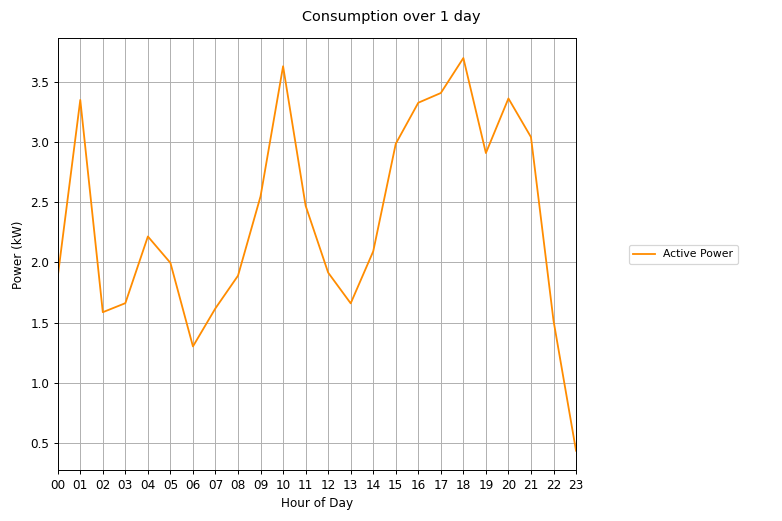

In [19]:
start = "2006-12-17 00:00:00"
end = "2006-12-17 23:00:00"

df = hourly_df[start:end]

# df = df.resample('30s').interpolate(methode='linear')
#df['sold_to_grid'] = df['bought_from_grid']
#df['bought_from_grid'].loc[df['bought_from_grid'].values < 0 ] = np.nan
#df['sold_to_grid'].loc[df['bought_from_grid'].values > 0 ] = np.nan
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True, 
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(df.index, df["global_active_power"], label="Active Power",
         color="darkorange", linewidth=1.5)
pax.grid(True)
#-----------------
pax.set_xlim([df.index[0], df.index[-1]])
pax.set_xticks(df.index.tolist())
pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H"))
# pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b %d"))
pax, lax = axs
pax.set_ylabel("Power (kW)")
pax.set_xlabel("Hour of Day")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)


# ----------------
fig.suptitle("Consumption over 1 day")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0, 0, 1, 0.95])
# savefig(fig_name='simulated_plot_site_cons', path=DIR_FIG)



In [20]:
hourly_df['hour'] = hourly_df.index.hour
hourly_df.index = hourly_df.index.date
pivot_df = hourly_df.pivot(columns='hour')

<IPython.core.display.Javascript object>


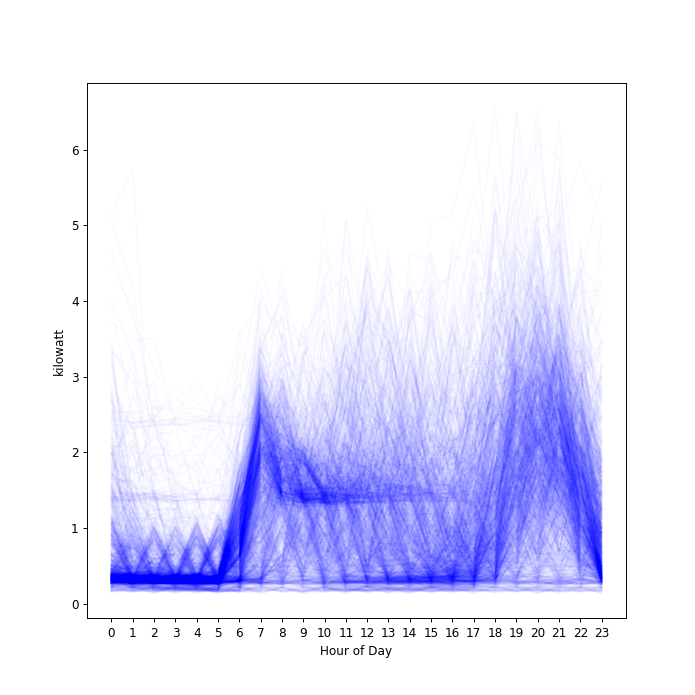

Text(0.5, 0, 'Hour of Day')

In [21]:
pivot_df = pivot_df.dropna()
ax = pivot_df.T.plot(figsize=(8,8), legend=False, color='blue', alpha=0.02)

list_hour = [i for i in range(24)]


ax.set_ylabel('kilowatt')
ax.set_xticks(list_hour)

ax.set_xticklabels(list_hour)
ax.set_xlabel('Hour of Day')


# Building Model

using clusters

In [22]:
sil_scores = []
n_cluster_list = np.arange(2,31).astype(int)

In [23]:
X = pivot_df.values.copy()

standard_scaler = MinMaxScaler()
X_prepared = standard_scaler.fit_transform(X)



In [24]:

for num_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=num_cluster, n_init=10)
    cluster_found = kmeans.fit_predict(X_prepared)
    sil_scores.append(silhouette_score(X, kmeans.labels_))    

In [25]:
sil_scores

[0.1921945409169593,
 0.13997822279535455,
 0.14209727331767996,
 0.13719595690395525,
 0.09516283822225365,
 0.09700587892683378,
 0.09695911075253706,
 0.09453332793628573,
 0.09474954279600258,
 0.09258006104013196,
 0.0930190268558108,
 0.08853117560864435,
 0.08732384949704813,
 0.0903458745345862,
 0.09099752605355962,
 0.08212226389844608,
 0.08606032843013454,
 0.0822271175449317,
 0.07599424066213015,
 0.07864926295443009,
 0.0809870746139428,
 0.07611259668221165,
 0.07566282301278748,
 0.08317011956112781,
 0.08302067824885892,
 0.07228888620153347,
 0.07503054043676358,
 0.07913944444778671,
 0.0722341882813656]

<IPython.core.display.Javascript object>


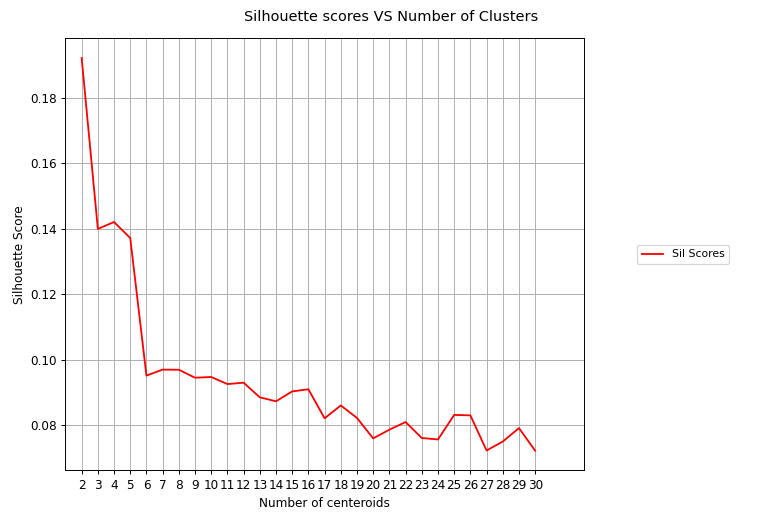

In [26]:
fig, axs = plt.subplots(1, 2, sharex=True, 
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(n_cluster_list, sil_scores, label="Sil Scores",
         color="red", linewidth=1.5)
pax.grid(True)
#-----------------
pax.set_xlim([1, 33])
pax.set_xticks(n_cluster_list)
# pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H"))
# pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b %d"))
pax, lax = axs
pax.set_ylabel("Silhouette Score")
pax.set_xlabel("Number of centeroids")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)


# ----------------
fig.suptitle("Silhouette scores VS Number of Clusters")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0, 0, 1, 0.95])
# savefig(fig_name='simulated_plot_site_cons', path=DIR_FIG)



In [27]:
kmeans = KMeans(n_clusters=3)

In [28]:
cluster_found = kmeans.fit_predict(X)

In [29]:
cluster_found_sr = pd.Series(cluster_found, name='cluster')

In [30]:
cluster_found_sr

0       0
1       0
2       2
3       0
4       2
       ..
1412    1
1413    0
1414    2
1415    2
1416    2
Name: cluster, Length: 1417, dtype: int32

In [31]:
pivot_df = pivot_df.set_index(cluster_found_sr, append=True)

<IPython.core.display.Javascript object>


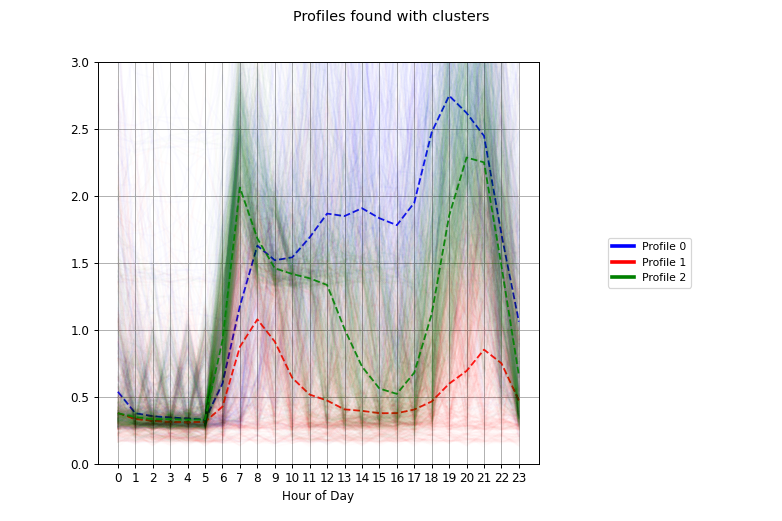

Text(0.5, 0.98, 'Profiles found with clusters')

In [32]:
fig, axs = plt.subplots(1, 2, sharex=True, 
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [4, 1]})


color_list = ['blue', 'red', 'green']

cluster_values = sorted(pivot_df.index.get_level_values('cluster').unique())

pax, lax = axs

for cluster, color in zip(cluster_values, color_list):
    pivot_df.xs(cluster, level=1).T.plot(
        ax=pax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    pivot_df.xs(cluster, level=1).median().plot(
        ax=pax, color=color, alpha=0.9, ls='--'
    )
pax.grid(True)
pax.set_xticks(list_hour)
pax.set_xticklabels(list_hour)
pax.set_xlabel('Hour of Day')
pax.set_ylim(bottom=0, top=3)


# legend

lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in color_list]
labels = ['Profile 0', 'Profile 1', 'Profile 2']
lax.legend(lines, labels, loc=10, fontsize=9)


fig.suptitle("Profiles found with clusters")


# Validating Results with TSNE

In [33]:
tsne = TSNE()
results_tsne = tsne.fit_transform(X)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

<IPython.core.display.Javascript object>


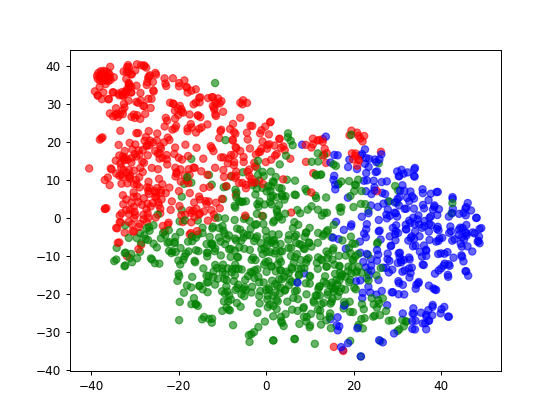

In [34]:
plt.figure()
plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=pivot_df.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6, 
    )